# Benchmark Analysis - H3

In [24]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [25]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [26]:
matplotlib.style.use('seaborn-v0_8')  

In [27]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [28]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [29]:
plot_save_dir = './plots/h3'

## Utils 

In [30]:
def get_path(*entries):
    return os.path.join(*entries)

In [31]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [32]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [33]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [34]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [35]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [36]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

# H3
> Some parallel backends exhibit better performance and scalability when handling nested parallelism for heterogeneous
> workloads

## `b1_1_for_each_linear_mandelbrot`

### Time Comparison - `b1_1_for_each_linear_mandelbrot`


Check how the runtime without constraining the threads develops with increasing input size

In [37]:
def get_b1_1_mandelbrot_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## load b1_1_for_each_linear_mandelbrot_par
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_1_for_each_linear_mandelbrot_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_1_mandelbrot_data_algo(*x) for x in instances]


# merge for plotting 
b1_1_mandelbrot_time_merged = pd.merge(*data, on='n')

# convert time from ns to microseconds because otherwise it will look really bad
for _, compiler_name in instances:
    b1_1_mandelbrot_time_merged[f'{compiler_name}'] = b1_1_mandelbrot_time_merged[f'{compiler_name}'] / 1_000

b1_1_mandelbrot_time_merged

,GCC(TBB),n,NVC(OMP)
0,12.8019,32,4.77709
1,17.7739,64,5.09185
2,22.7703,128,5.25487
3,26.7095,256,6.02726
4,30.4538,512,5.44850
5,34.2132,1024,6.84551
6,33.4617,2048,6.99482
7,35.9201,4096,9.95727
8,40.3139,8192,14.45940
9,46.2349,16384,24.40760


### Strong scaling - `b1_1_for_each_linear_mandelbrot`
 
1 Million fixed input size with threads 1-64

In [38]:
def get_b1_1_mandelbrot_strong_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## b1_1_for_each_linear_mandelbrot_threaded
    df = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                               'b1_1_for_each_linear_mandelbrot_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                            )
    
    seq_base = extraction_pandas_frame_algo(
        root_dir + f'/{compiler_location}/DEFAULT/b1_1_for_each_linear_mandelbrot_seq__Default.csv',
        COMP=compiler_name)

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_1_mandelbrot_strong_scaling_algo(*x) for x in instances]

b1_1_for_each_linear_mandelbrot_strong_scaling_merged = pd.merge(*data, on='threads')

b1_1_for_each_linear_mandelbrot_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.000570,0.947488
1,2,2.001016,1.393265
2,4,4.000917,1.737865
3,8,7.984752,3.194978
4,16,15.946725,4.135724
5,32,31.488160,7.496376


In [39]:
# efficiency graph

b1_1_for_each_linear_mandelbrot_efficiency = b1_1_for_each_linear_mandelbrot_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b1_1_for_each_linear_mandelbrot_efficiency[f'{compiler_name}'] = b1_1_for_each_linear_mandelbrot_efficiency[f'{compiler_name}'] / b1_1_for_each_linear_mandelbrot_efficiency['threads']
    

b1_1_for_each_linear_mandelbrot_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.000570,0.947488
1,2,1.000508,0.696633
2,4,1.000229,0.434466
3,8,0.998094,0.399372
4,16,0.996670,0.258483
5,32,0.984005,0.234262


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41670/1739907466.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


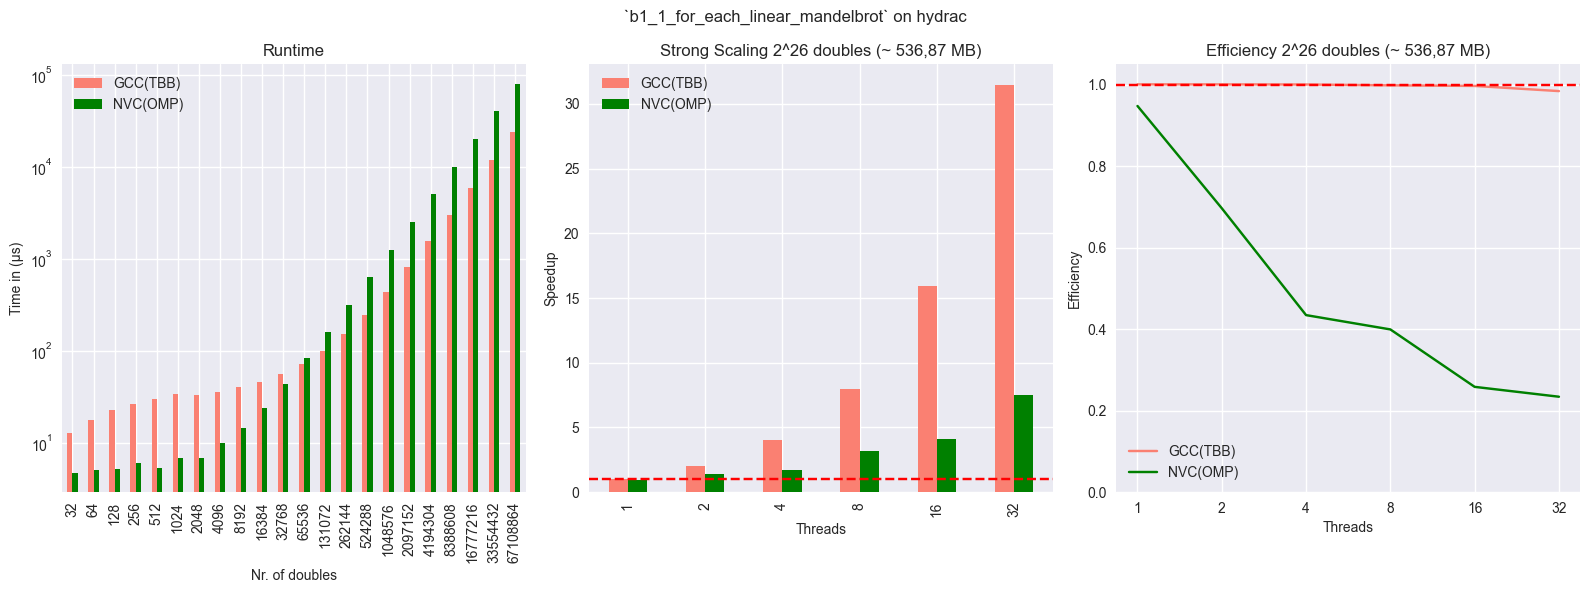

In [40]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# runtime
ax_1 = b1_1_mandelbrot_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
ax_1.set_ylabel('Time in (µs)')
ax_1.set_xlabel('Nr. of doubles')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b1_1_for_each_linear_mandelbrot_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 doubles (~ 536,87 MB)')




# plot efficiency
ax_3 = b1_1_for_each_linear_mandelbrot_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.05)

plt.xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 doubles (~ 536,87 MB)')



fig.suptitle("`b1_1_for_each_linear_mandelbrot` on hydrac")

fig.tight_layout()

plot("`b1_1_for_each_linear_mandelbrot` on hydrac")

### Instructions Per Seconds

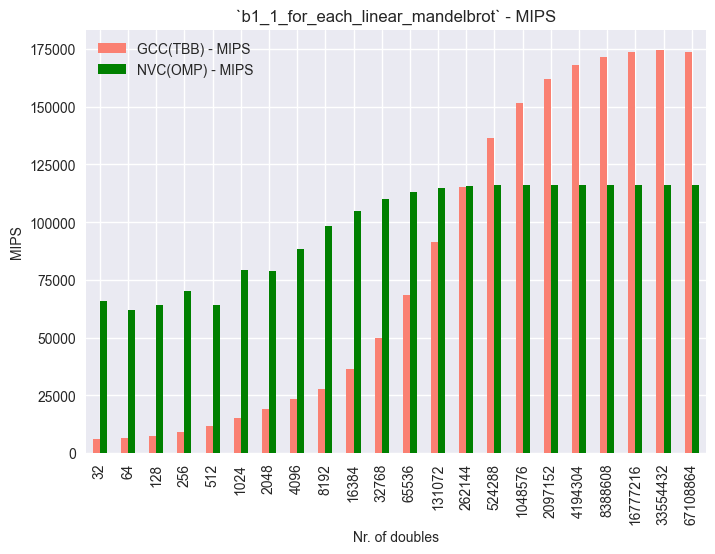

In [41]:
def get_instructions(compiler_location:str,compiler_name:str,benchmark_name:str):
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/INSTRUCTIONS/{benchmark_name}__Instructions.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    
    # convert to seconds
    df['real_time'] = df['real_time'] / 1_000_000_000

    # calc ips and mips
    df['IPS'] = df['INSTRUCTIONS'] / df['real_time'] 
    df['MIPS'] = df['IPS'] * pow(10,-6)

    # remove useless columns
    df = df.drop(columns=['real_time','INSTRUCTIONS','IPS'])

    df = df.rename(columns={'MIPS': f'{compiler_name} - MIPS'})

    return df


# collect data for instances
data = [get_instructions(*x,'b1_1_for_each_linear_mandelbrot_par') for x in instances]

b1_1_for_each_linear_mandelbrot_ips_merged = pd.merge(*data, on='n')

b1_1_for_each_linear_mandelbrot_ips_merged.plot(kind='bar',x='n',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])


plt.ylabel('MIPS')
plt.xlabel('Nr. of doubles')
plt.title('`b1_1_for_each_linear_mandelbrot` - MIPS')

plot('`b1_1_for_each_linear_mandelbrot` - MIPS')

## `b1_2_for_each_quadratic_mandelbrot`

### Time Comparison - `b1_2_for_each_quadratic_mandelbrot`

Check how the runtime without constraining the number of threads develops with increasing the input size

In [42]:
def get_b1_2_mandelbrot_data_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## load b1_2_for_each_quadratic_mandelbrot_par_par
    df_par_par = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_par__Default.csv',COMP=compiler_name)

    df_par_par = df_par_par.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df_par_par = df_par_par.rename(columns={'real_time':f'{compiler_name}'})

    ## load b1_2_for_each_quadratic_mandelbrot_par_seq
    """df_par_seq = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_seq__Default.csv',COMP=compiler_name)

    df_par_seq = df_par_seq.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df_par_seq = df_par_seq.rename(columns={'real_time':f'{compiler_name} - par_seq'})"""


    return df_par_par


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_mandelbrot_data_algo(*x) for x in instances]

# merge for plotting 
b1_2_mandelbrot_time_merged = pd.merge(*data, on='n')

# convert time from ns to microseconds because otherwise it will look really bad
for _, compiler_name in instances:
    b1_2_mandelbrot_time_merged[f'{compiler_name}'] = b1_2_mandelbrot_time_merged[f'{compiler_name}'] / 1_000
    #b1_2_mandelbrot_time_merged[f'{compiler_name} - par_seq'] = b1_2_mandelbrot_time_merged[f'{compiler_name} - par_seq'] / 1_000


b1_2_mandelbrot_time_merged

,GCC(TBB),n,NVC(OMP)
0,43.9920,32,7.21538
1,77.7721,64,10.02110
2,157.6220,128,14.80310
3,339.2770,256,26.27840
4,780.8300,512,51.98150
5,1964.9400,1024,119.56000
6,5380.4700,2048,409.41400
7,11387.9000,4096,1609.67000
8,26152.1000,8192,6021.40000
9,66271.8000,16384,22561.90000


### Strong scaling - `b1_2_for_each_quadratic_mandelbrot`

32768 fixed input size with threads 1-64

In [43]:
def get_b1_2_mandelbrot_strong_scaling_algo(compiler_location:str,compiler_name:str) -> pd.DataFrame:
    ## Threading data par_par
    par_par_threads = extraction_pandas_frame_algo_threaded(root_dir + f'/{compiler_location}/THREADS',
                                                                                    'b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_par',
                                                                                    [1,2,4,8,16,32],
                                                                                    COMP=compiler_name,
                                                                                    input_size=32768
                                                                                )
    
    seq_base = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/b1_2_for_each_quadratic_mandelbrot_outer_std::execution::sequenced_policy_seq__Default.csv',COMP=compiler_name)

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,par_par_threads,
                                                    f"{compiler_name}", 
                                                    input_size=32768
                                                )


# load b1_2_for_each_quadratic_mandelbrot_threaded 

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

# collect data for instances
data = [get_b1_2_mandelbrot_strong_scaling_algo(*x) for x in instances]

b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged = pd.merge(*data, on='threads')


b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.494702,0.902686
1,2,0.992219,1.805379
2,4,1.984113,3.610508
3,8,3.940830,7.207913
4,16,7.881504,14.409515
5,32,15.694259,28.809847


In [44]:
# efficiency graph


b1_2_for_each_quadratic_mandelbrot_efficiency = b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged.copy()


instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

for _,compiler_name in instances:
    b1_2_for_each_quadratic_mandelbrot_efficiency[f'{compiler_name}'] = b1_2_for_each_quadratic_mandelbrot_efficiency[f'{compiler_name}'] / b1_1_for_each_linear_mandelbrot_efficiency['threads']
    

b1_2_for_each_quadratic_mandelbrot_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.494702,0.902686
1,2,0.496109,0.902689
2,4,0.496028,0.902627
3,8,0.492604,0.900989
4,16,0.492594,0.900595
5,32,0.490446,0.900308


/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_41670/4037837019.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


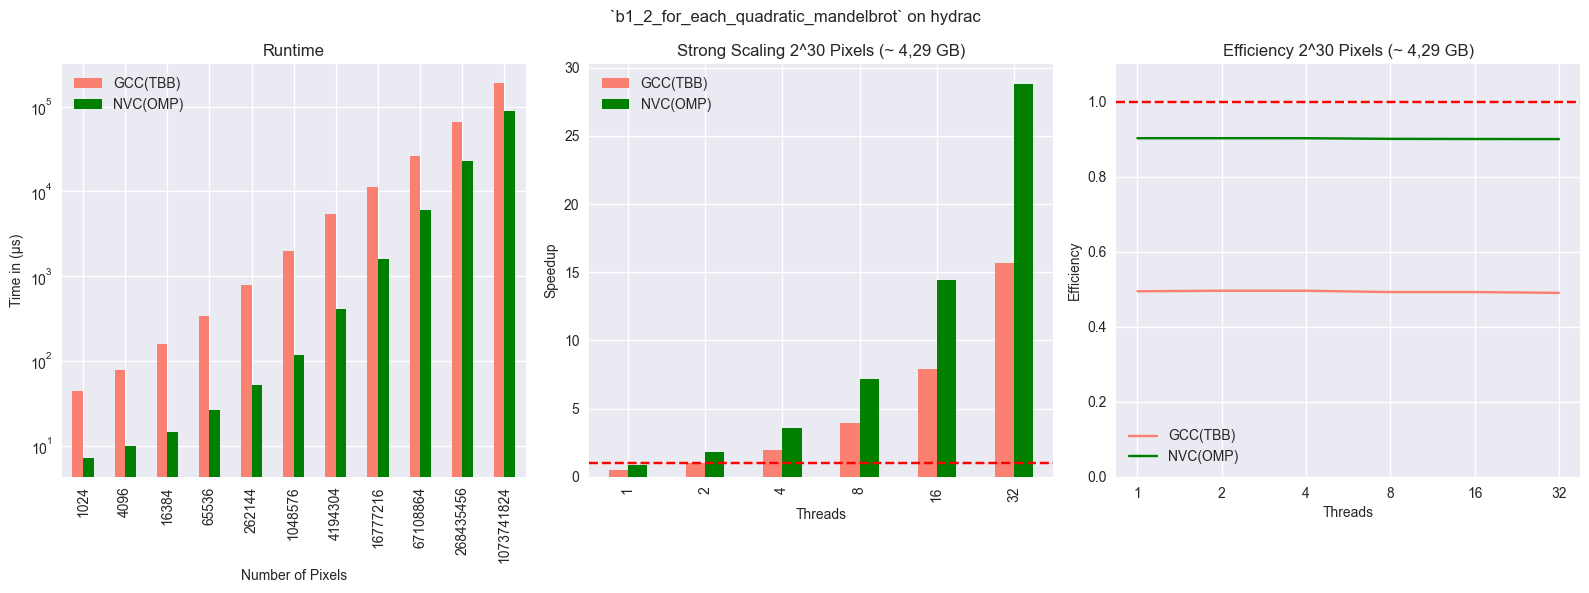

In [45]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))

# change the 'n' because we want to say the number of pixels
b1_2_mandelbrot_time_merged_for_plotting = b1_2_mandelbrot_time_merged.copy()
b1_2_mandelbrot_time_merged_for_plotting['n'] = b1_2_mandelbrot_time_merged_for_plotting['n'] * b1_2_mandelbrot_time_merged_for_plotting['n']

# runtime
ax_1 = b1_2_mandelbrot_time_merged_for_plotting.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR],ax=axes[0])

ax_1.set_yscale('log', base=10)
#ax_1.set_xscale('log',base=10)
ax_1.set_ylabel('Time in (µs)')
ax_1.set_xlabel('Number of Pixels')
ax_1.set_title('Runtime')



# plot strong scaling
ax_2 = b1_2_for_each_quadratic_mandelbrot_strong_scaling_merged.plot(kind='bar',
                                                        x='threads',
                                                        align='center',
                                                        color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                        ax=axes[1]
                                                    )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')


ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^30 Pixels (~ 4,29 GB)')




# plot efficiency
ax_3 = b1_2_for_each_quadratic_mandelbrot_efficiency.plot(x='threads',
                                             color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                             ax=axes[2]
                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.10)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^30 Pixels (~ 4,29 GB)')



fig.suptitle("`b1_2_for_each_quadratic_mandelbrot` on hydrac")

fig.tight_layout()


plot("`b1_2_for_each_quadratic_mandelbrot` on hydrac")

### IPS

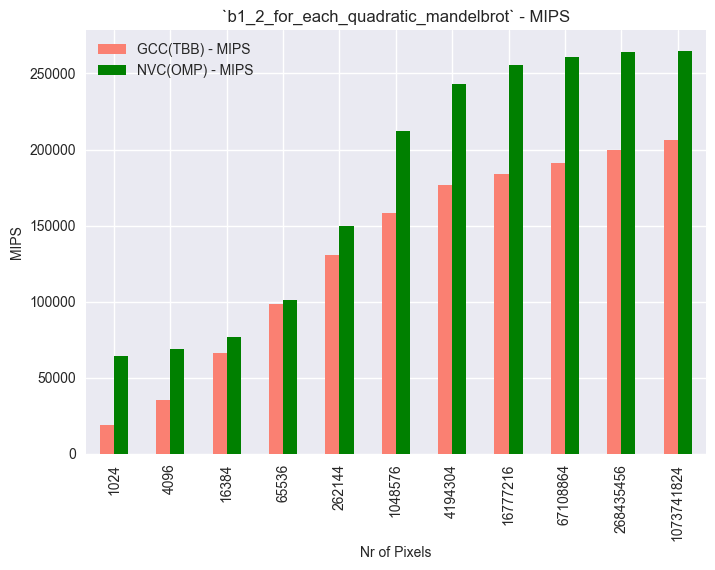

In [46]:
def get_instructions(compiler_location:str,compiler_name:str,benchmark_name:str):
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/INSTRUCTIONS/{benchmark_name}__Instructions.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    
    # convert to seconds
    df['real_time'] = df['real_time'] / 1_000_000_000

    # calc ips and mips
    df['IPS'] = df['INSTRUCTIONS'] / df['real_time'] 
    df['MIPS'] = df['IPS'] * pow(10,-6)

    # remove useless columns
    df = df.drop(columns=['real_time','INSTRUCTIONS','IPS'])

    df = df.rename(columns={'MIPS': f'{compiler_name} - MIPS'})

    return df


# collect data for instances
data = [get_instructions(*x,'b1_2_for_each_quadratic_mandelbrot_outer_std::execution::parallel_policy_par') for x in instances]

b1_2_for_each_quadratic_mandelbrot_ips_merged = pd.merge(*data, on='n')

# change the 'n' because we want to say the number of pixels
b1_2_for_each_quadratic_mandelbrot_ips_merged['n'] = b1_2_for_each_quadratic_mandelbrot_ips_merged['n'] * b1_2_for_each_quadratic_mandelbrot_ips_merged['n']


b1_2_for_each_quadratic_mandelbrot_ips_merged.plot(kind='bar',x='n',color=[GCC_TBB_COLOR,NVC_OMP_COLOR])


plt.ylabel('MIPS')
plt.xlabel('Nr of Pixels')
plt.title('`b1_2_for_each_quadratic_mandelbrot` - MIPS')

plot('`b1_2_for_each_quadratic_mandelbrot` - MIPS')

## Performance Portability Calculation (Inter Compiler)

NONE

## Findings for H3


### Findings `b1_1_for_each_linear_mandelbrot`

From our runtime analysis we can see that GCC(TBB) has significant better performance than NVC(OMP). For small input sizes up to 2^16 the performance is about the same for both backends. For larger heterogenous workloads the performance of NVC(OMP) collapses and GCC(TBB) shines with its rather fast runtime. I cannot confirm this because I have not read through the code but I can remember to have read that GCC(TBB) does work stealing. This would explain why GCC(TBB) performs so good in comparison.

This poor performance of NVC(OMP) continues when looking at its strong scaling behavior. Already for small number of threads (4) the speedup is really poorly leading to efficiency of 40% and less. Compared to NVC(OMP), GCC(TBB) has fairly good strong scaling. Although for higher number of threads it seems to slowly top off. Moving from 32 to 64 threads does not bring a huge improvement.

//TODO: IPS

Key Observations:
* GCC(TBB) works really well with heterogenous workloads.
* NVC(OMP) struggles a lot with large input sizes 
* NVC(OMP) has really bad strong scaling 
* GCC(TBB) great scaling but slows down at 32->64 threads

### Findings `b1_2_for_each_quadratic_mandelbrot`

The runtime analysis shows that GCC(TBB) has quite bad runtime compared to NVC(OMP). The runtime of NVC(OMP) especially on smaller input sizes is by a magnitude faster. For larger input sizes NVC(OMP) slowly gets worse but still way better than GCC(TBB). 

Strong Scaling is quite interesting for GCC(TBB). For up to 16 threads we have perfect speedup, for 32 and 64 threads we have around 80-90% efficiency. NVC(OMP) nearly follows this trend, since perfect speedup stops at 8 threads and even before we seem to be around 99% all the time. From 16 till 64 threads the speedup seems to be stable not with an efficiency of about 80%.

//TODO: IPS

Key Observations:
* GCC(TBB) runtime is quite bad comparing to NVC(OMP)
* NVC(OMP) has great runtime for small input sizes but for larger input sizes it collapses.
* Strong Scaling of GCC(TBB) is quite strange. Perfect speedup until 16 threads. Then slowly degrades
* NVC(OMP) Strong scaling nearly perfect speedup until 8 Threads. Then collapses really fast.


### GPU Findings

Although it is possible to rewrite the code of b1_1_linear_mandelbrot to run on gpus hydra does not support GPUS.


## Hypothesis Findings

This hypothesis is **true**!
